# UMAP analysis for seismic coda waves



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import scipy as sp


from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from scatseisnet import ScatteringNetwork

from tqdm import tqdm
from matplotlib import colors
from sklearn.decomposition import PCA

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator




/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


# Example usage:
# filtered_data_lp = apply_sosfilter(data_records_vs, freqmax, sr, filter_type='lp')
# filtered_data_hp = apply_sosfilter(data_records_vs, freqmax, sr, filter_type='hp')
# filtered_data_bp = apply_sosfilter(data_records_vs, (low_freq, high_freq), sr, filter_type='bp')

In [2]:
freqmax = 8
sr = 40
reduce_type = np.mean

name_fig = 'FIGURES_UMAP_SPACE'

name = f"{name_fig}"
savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"
os.makedirs(savepath, exist_ok=True)



In [3]:


FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs_hr = np.load(FILEPATH+'vs_map_2400x1300.npy')
vs_hr = vs_hr/1000

vs = np.load(FILEPATH+'vs_array.npy') 
vs = vs/1000

data_records_vs = []
for i in range(1, 6):
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/z_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/z_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_vs.append(data_read)
data_records_vs = np.array(data_records_vs) 

sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_vs = sosfiltfilt(sos, data_records_vs[:,:,:], axis=-1)
data_records_vs = np.concatenate(data_records_vs, axis = 1)
#data_records_vs = data_records_vs[:, :, ::2]

data_records_hs = []
for i in range(1, 6):    
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/x_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/x_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_hs.append(data_read)
data_records_hs = np.array(data_records_hs)


sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_hs = sosfiltfilt(sos, data_records_hs[:,:,:], axis=-1)
data_records_hs = np.concatenate(data_records_hs, axis = 1)
#data_records_hs = data_records_hs[:, :, ::2]



In [4]:
sr = 40

x_dist = (10000+100*np.arange(65))/1000
y_dist = (2500+100*np.arange(120))/1000

y_dist.min(), y_dist.max()

time_ = np.arange(0, data_records_hs.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]

x_dist_hr = np.arange(10, 16.5, .005)
y_dist_hr = np.arange(2.5, 14.5, .005)



In [5]:



segment_duration_seconds = data_records_hs.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
        {"octaves": 4, "resolution": 5, "quality": 2, "normalize_wavelet": 'l2'},
        {"octaves": 5, "resolution": 2, "quality": 3, "normalize_wavelet": 'l2'},
            
    )


bank_keyword_arguments = (
        {"octaves": 4, "resolution": 5, "quality": 2, "normalize_wavelet": 'l2'},
        {"octaves": 6, "resolution": 2, "quality": 3, "normalize_wavelet": 'l2'},
        )

network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=5, quality=2, sampling_rate=40, len=20)
ComplexMorletBank(bins=1500, octaves=6, resolution=2, quality=3, sampling_rate=40, len=12)


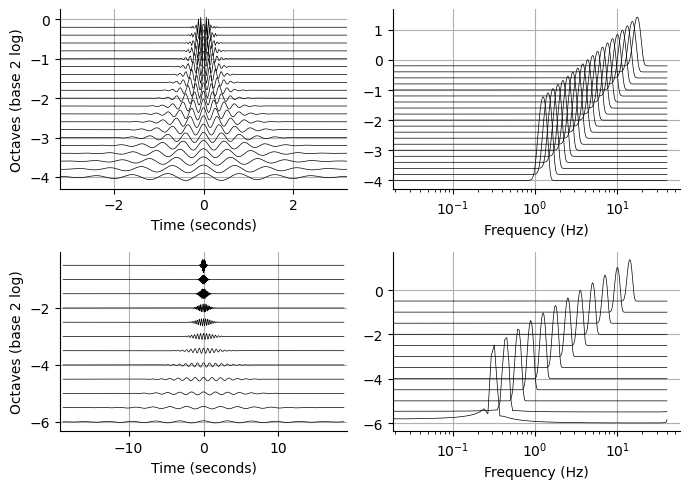

In [6]:

fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)

        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)

    width_max = 2 * bank.widths.max()

    # Labels
    

    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
#fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)


In [7]:
segments = [data_records_hs[i,:,:] for i in indxvs[indx, 30]]

sc1 = network.transform(segments,  reduce_type= None )



In [8]:


sc_med__hs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_hs_median_40.npz"
sc_med__vs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_vs_median_40.npz"

sc_med__hs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_hs_2_median_40.npz"
sc_med__vs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_vs_2_median_40.npz"

# sc_med_20_hs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_com_hs_average_20.npz"
# sc_med_20_vs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_com_vs_average_20.npz"

scattering_coeff_vs = reader_coeff(sc_med__vs, network = network)
scattering_coeff_hs = reader_coeff(sc_med__hs, network = network)



In [226]:

randint = np.random.randint(0, 7800, int(7800*0.9))


In [235]:

# scattering_coef_vs_norm = preprocessing_(scattering_coeff_vs, scaler = RobustScaler())
# scattering_coef_hs_norm = preprocessing_(scattering_coeff_hs, scaler = RobustScaler())

scattering_coef_vs_norm = preprocessing_(scattering_coeff_vs, scaler = MinMaxScaler(feature_range = (-1, 1)))
scattering_coef_hs_norm = preprocessing_(scattering_coeff_hs, scaler = MinMaxScaler(feature_range = (-1, 1)))

UMAP_model = []
UMAP_space = []

for i, coeff_ in enumerate([scattering_coef_vs_norm, scattering_coef_hs_norm]):
    model_umap = umap.UMAP(
        n_neighbors = 30,
        min_dist = 0.1,
        n_components = 2,
        random_state = 42,
        metric = 'manhattan',
        #local_connectivity = 10,
        low_memory = False,
        )
    
    UMAP_space.append(model_umap.fit_transform(coeff_[randint]))
    UMAP_model.append(model_umap)

    print(f'UMAP {i} done')
    

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP 0 done


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP 1 done


/tmp/ipykernel_74786/2207850707.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k',
/tmp/ipykernel_74786/2207850707.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


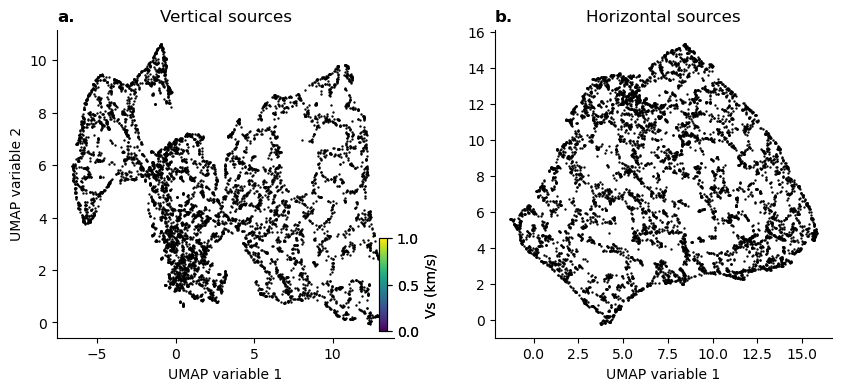

In [236]:

gs = {"hspace": 0.4, "wspace": 0.3, "width_ratios": [2, 2]}
fig, axs = plt.subplots(
        1, 2, figsize=(10, 4),  gridspec_kw=gs,)

tit = ['station R3', 'combined-seismograms']
tit_ind = ['a', 'd']

vs_plotindex = [15, 30, 45]

for i, umap_data in enumerate(UMAP_space):
    ax = axs
    im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k', 
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        cmap = 'RdBu', s = 0.5, alpha = 1, rasterized=True)
    
    # for j in vs_plotindex:
    #     im = ax[i].scatter(umap_data[indxvs[:, j], 0], umap_data[indxvs[:, j], 1], c = vs.reshape(-1)[indxvs[:, j]][randint],
    #                         vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
    #                         cmap = 'RdBu', s = 20, alpha = 1, rasterized=True)


    axins1 = inset_axes(ax[0], width="2.5%", height="30%", loc="lower right",)
    axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Vs (km/s)')
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    ax[i].set_xlabel('UMAP variable 1')
ax[0].set_ylabel('UMAP variable 2')

[axs[i].set_title(f) for i, f in enumerate(['Vertical sources', 'Horizontal sources'])]


tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']
for i in range(2):
    axs.reshape(-1)[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

    
fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas_2" + ".png", bbox_inches="tight", dpi=300, transparent=True,)




In [237]:

LOC_DIM = []

for i , umodel in enumerate(UMAP_model):
    print(f'UMAP for data {i}')
    LOC_DIM.append(calculate_local_dimension(umodel, threshold = 0.8))
    

UMAP for data 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7020/7020 [00:23<00:00, 296.18it/s]


UMAP for data 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7020/7020 [00:23<00:00, 297.88it/s]


In [231]:
# from scipy.interpolate import RectBivariateSpline
# from scipy.interpolate import interpn


# xx = np.repeat(x_dist , 120)
# yy = np.repeat(y_dist, 65)

# dddd = np.zeros_like(yy)

# for i in range(7800):

#     interp = interpn((xx[randint][:], yy[randint][:]), LOC_DIM[0][:], np.array([xx[i], yy[i]])[:, np.newaxis])
#     dddd[i] =interp 

# #ff = interp(xx, yy)



# #plt.imshow(ff.reshape(120, 65), cmap ='RdBu_r')

In [ ]:
np.array([xx[i], yy[i]])

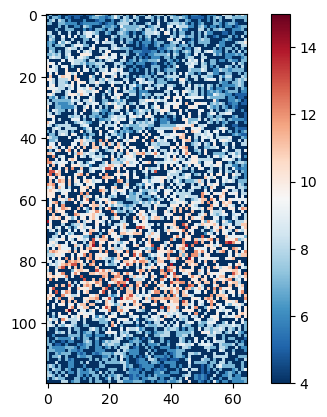

In [246]:

ddim = np.zeros(7800)+  np.min(LOC_DIM[1])
#ddim[:] = np.nan

ddim[randint] = LOC_DIM[1]

plt.imshow(sp.ndimage.gaussian_filter(ddim.reshape(120, 65), 0, order = 0), cmap = 'RdBu_r')
plt.colorbar()



/tmp/ipykernel_74786/1682833072.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im = axs.scatter(umap_data[:, 0], umap_data[:, 1], c = 'k',
/tmp/ipykernel_74786/1682833072.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


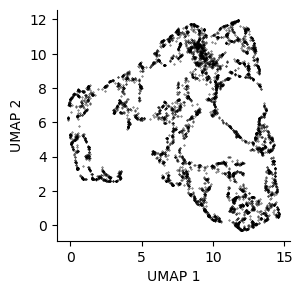

In [101]:

umap_data = UMAP_space[1]

gs = {"hspace": 0.4, "wspace": 0.3, "width_ratios": [2]}
fig, axs = plt.subplots(
        1, 1, figsize=(3, 3),  gridspec_kw=gs,)
cmap = plt.get_cmap('RdBu_r', np.max(LOC_DIM[1]) - np.min(LOC_DIM[1]) + 1)

im = axs.scatter(umap_data[:, 0], umap_data[:, 1], c = 'k', 
                        cmap = 'RdBu', s = 0.1, alpha = 1, rasterized=True)

# axins1 = inset_axes(axs, width="5%", height="50%", loc="upper right",)
# axins1.xaxis.set_ticks_position("top")
# fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Complexity')

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.set_xlabel('UMAP 1')
axs.set_ylabel('UMAP 2')

fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas__one" + ".png", bbox_inches="tight", dpi=300, transparent=True)



TypeError: 'Axes' object is not subscriptable

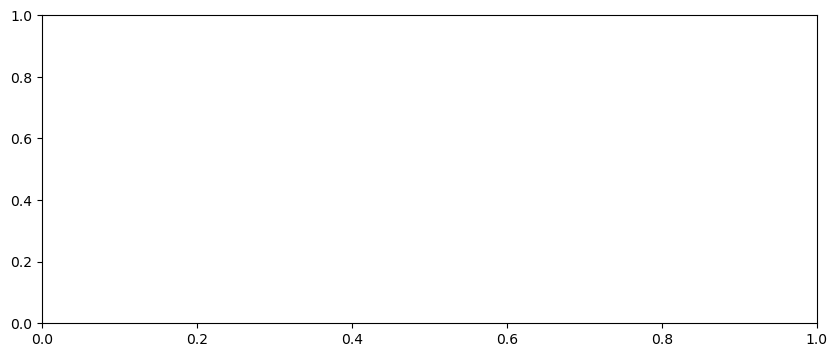

In [27]:

gs = {"hspace": 0.4, "wspace": 0.3, "width_ratios": [2]}
fig, axs = plt.subplots(
        1, 1, figsize=(10, 4),  gridspec_kw=gs,)

tit = ['station R3', 'combined-seismograms']
tit_ind = ['a', 'd']

vs_plotindex = [15, 30, 45]

for i, umap_data in enumerate(UMAP_space):
    ax = axs
    im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k', 
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        cmap = 'RdBu', s = 0.5, alpha = 1, rasterized=True)
    
    for j in vs_plotindex:
        im = ax[i].scatter(umap_data[indxvs[:, j], 0], umap_data[indxvs[:, j], 1], c = vs.reshape(-1)[indxvs[:, j]],
                            vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                            cmap = 'RdBu', s = 20, alpha = 1, rasterized=True)


    axins1 = inset_axes(ax[0], width="2.5%", height="30%", loc="lower right",)
    axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Vs (km/s)')
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    ax[i].set_xlabel('UMAP variable 1')
ax[0].set_ylabel('UMAP variable 2')

[axs[i].set_title(f) for i, f in enumerate(['Vertical sources', 'Horizontal sources'])]


tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']
for i in range(2):
    axs.reshape(-1)[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

    
fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas__one" + ".png", bbox_inches="tight", dpi=300, transparent=True,)




/tmp/ipykernel_58829/366790441.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  im = ax[0].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k',
/tmp/ipykernel_58829/366790441.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


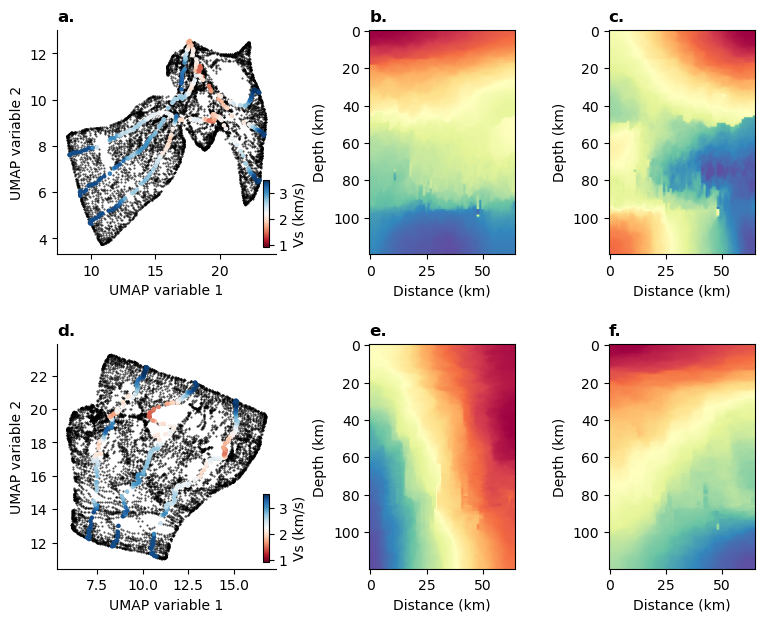

In [28]:

gs = {"hspace": 0.4, "wspace": 0.55, "width_ratios": [3,2, 2]}
fig, axs = plt.subplots(
        2, 3, figsize=(9, 7),  gridspec_kw=gs,)

tit = ['station R3', 'combined-seismograms']
tit_ind = ['a', 'd']

for i, umap_data in enumerate(UMAP_space):
    ax = axs[i]
    im = ax[0].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k', 
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        cmap = 'RdBu', s = 0.25, alpha = 0.75, rasterized=True)


    im = ax[0].scatter(umap_data[indxvs[:, 15], 0], umap_data[indxvs[:, 15], 1], c = vs.reshape(-1)[indxvs[:, 15]],
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)
    
    im = ax[0].scatter(umap_data[indxvs[:, 30], 0], umap_data[indxvs[:, 30], 1], c = vs.reshape(-1)[indxvs[:, 30]],
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)

    im = ax[0].scatter(umap_data[indxvs[:, 45], 0], umap_data[indxvs[:, 45], 1], c = vs.reshape(-1)[indxvs[:, 45]], 
                       vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(), 
                       cmap = 'RdBu', s = 5, alpha = 1, rasterized=True)
    

    axins1 = inset_axes(ax[0], width="2.5%", height="30%", loc="lower right",)
    axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Vs (km/s)')
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_xlabel('UMAP variable 1')
    ax[0].set_ylabel('UMAP variable 2')
    
    for j in range(2):
        im = ax[j+1].imshow(umap_data[:, j].reshape(120, 65), cmap = 'Spectral', 
                            vmin = umap_data[:, j].min(), vmax = umap_data[:, j].max()*1, 
                            rasterized = True, aspect = 'auto')
        #ax[i].axis('off')

        ax[j+1].set_ylabel('Depth (km)')
        ax[j+1].set_xlabel('Distance (km)')

tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(6):
    axs.reshape(-1)[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


/tmp/ipykernel_58829/1197013016.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


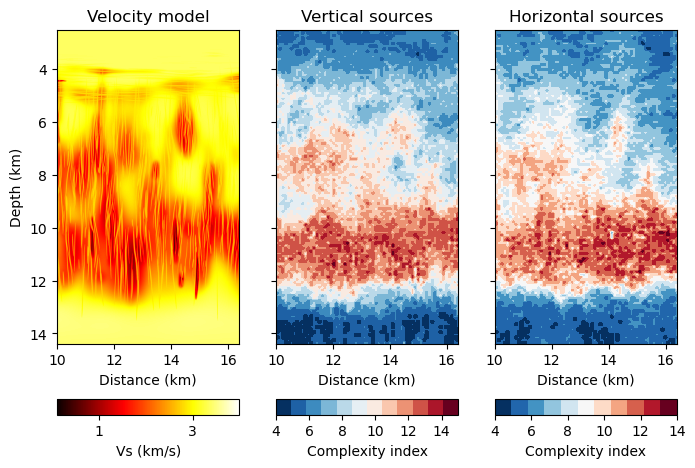

In [29]:

gs = {"hspace": 0.0, "wspace": 0.2, "width_ratios": [1, 1,  1]}
fig, axs = plt.subplots(
    1, 3, figsize=(8, 5),  gridspec_kw=gs, sharex = True, sharey = True,
    )
im1 = axs[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, aspect = 'auto')


axs[0].set_ylim(y_dist.max(), y_dist.min())
axs[0].set_ylabel('Depth (km)')
axs[0].set_xlabel('Distance (km)')
#axs[0].axis('off')
# 
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(1, 21 + 1)[::2])
cbar.set_label('Vs (km/s)')

for i, loc_dim in enumerate(LOC_DIM):
    cmap = plt.get_cmap('RdBu_r', np.max(loc_dim) - np.min(loc_dim) + 1)
    
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = axs[i+1].imshow(loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto', rasterized = True)
    axs[i+1].set_ylim(y_dist.max(), y_dist.min())
    axs[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    axs[i+1].set_xlabel('Distance (km)')
    divider = make_axes_locatable(axs[i+1])
    cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(np.min(loc_dim), np.max(loc_dim) + 1)[::2])
    cbar.set_label('Complexity index')


[axs[i].set_title(f) for i, f in enumerate(['Velocity model', 'Vertical sources', 'Horizontal sources'])]

fig.tight_layout()
fig.savefig(savepath + "UMAP_LOCAL_DIMENSIONALITY" + ".png", bbox_inches="tight", dpi=300, transparent=True,)

    


/tmp/ipykernel_58829/1995969871.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


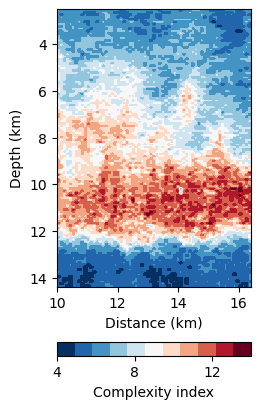

In [30]:
gs = {"hspace": 0.0, "wspace": 0.2, "width_ratios": [1]}
fig, axs = plt.subplots(
    1, 1, figsize=(2.5, 4.5),  gridspec_kw=gs, sharex = True, sharey = True,
    )
loc_dim = LOC_DIM[1]
cmap = plt.get_cmap('RdBu_r', np.max(LOC_DIM[1]) - np.min(LOC_DIM[1]) + 1)
    
#im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
im1 = axs.imshow(LOC_DIM[1].reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto', rasterized = True)
 
divider = make_axes_locatable(axs)
cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(np.min(loc_dim), np.max(loc_dim) + 1)[::4])

cbar.set_label('Complexity index')
axs.set_xlabel('Distance (km)')
axs.set_ylabel('Depth (km)')


fig.tight_layout()
fig.savefig(savepath + "UMAP_LOCAL_DIMENSIONALITY_one" + ".png", bbox_inches="tight", dpi=300, transparent=True,)

    


In [31]:
def fft_(data, n):
    
    nn = n//2
    return np.abs(np.fft.fft(data, n = n))[...,:nn], np.arange(nn)/(2*nn)



In [79]:
9/1.5

6.0

/tmp/ipykernel_58829/3871562190.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


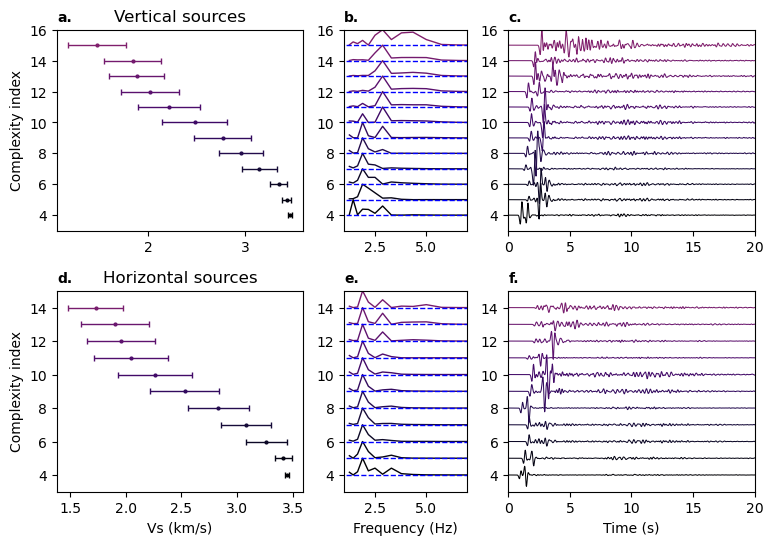

In [85]:

gs = {"hspace": 0.3, "wspace": 0.2, "width_ratios": [4,  2, 4]}

fig, axs = plt.subplots(
    2, 3, figsize=(9, 6),  gridspec_kw=gs, 
    )


sourceindex = 4

for i, d, sc, data_records in zip(range(2),[LOC_DIM[0], LOC_DIM[1]], [scattering_coeff_vs, scattering_coeff_hs], [data_records_vs, data_records_hs]):
    locdim = d
    dim = np.unique(locdim[::1])
    
    cmap = plt.get_cmap('inferno', len(dim)+20)

    for j, dimen in enumerate(dim[::1]):
        indx = locdim == dimen
        vsselected = vs.reshape(-1)[indx]
        depth = np.repeat(y_dist, 65)[indx]

        dd = data_records[np.where(indx)[0]][:, :, :]
        dd = dd[0, 4]/ np.max(abs(dd[0, 5]))/1.1
        
        bplot = axs[i][0].errorbar(np.mean(vsselected), dimen, xerr = np.std(vsselected), fmt = 'o', lw =1 , markersize = 2, capsize = 2, capthick = 1, c = cmap(j))

        sc_selected = np.mean(np.mean(sc[0][np.where(indx)[0]][:, 4:5,:] - 1 *np.mean(sc[0][:, :4:5,:], 0), axis =0), axis = 0)
        sc_selected = abs(sc_selected)**2
        sc_selected = sc_selected / np.max(abs(sc_selected))

        axs[i][1].plot(network.banks[0].centers, 1*(sc_selected) + dimen,  lw = 1 , c = cmap(j))
        axs[i][1].hlines(dimen,0, network.banks[0].centers.max(), lw = 1, linestyle = '--', color = 'b')

        axs[i][1].set_xlim(1, 7)

        axs[i][2].plot(time_, dd + dimen, c = cmap(j), lw = 0.75)

    axs[i][0].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i][1].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i][2].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i][2].set_xlim(0., 20)

    axs[i][0].set_ylabel('Complexity index')
axs[1][0].set_xlabel('Vs (km/s)')
axs[1][1].set_xlabel('Frequency (Hz)')
axs[1][2].set_xlabel('Time (s)')


titname = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(axs.reshape(-1))):
    axs.reshape(-1)[i].set_title(titname[i]+'.', loc = 'left', fontsize = 10, fontweight = 'bold')

axs[0][0].set_title('Vertical sources')
axs[1][0].set_title('Horizontal sources')


fig.tight_layout()
fig.savefig(savepath + "local_dimensionality_in_waveform" + ".png", bbox_inches="tight", dpi=300, transparent=True, )


In [48]:
corr_length_data = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/data_processed/corr_length.npy')

std_mean_ = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/data_processed/std_mean_500m.npy')

corr_smooth = sp.ndimage.gaussian_filter(corr_length_data, 0.8)


<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_58829/3624116745.py:9: SyntaxWarning: invalid escape sequence '\e'
  for i, par, title, cvalues in zip([0, 1], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):
/tmp/ipykernel_58829/3624116745.py:57: SyntaxWarning: invalid escape sequence '\e'
  axs[1, 1].set_ylabel('$\epsilon$')
/tmp/ipykernel_58829/3624116745.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


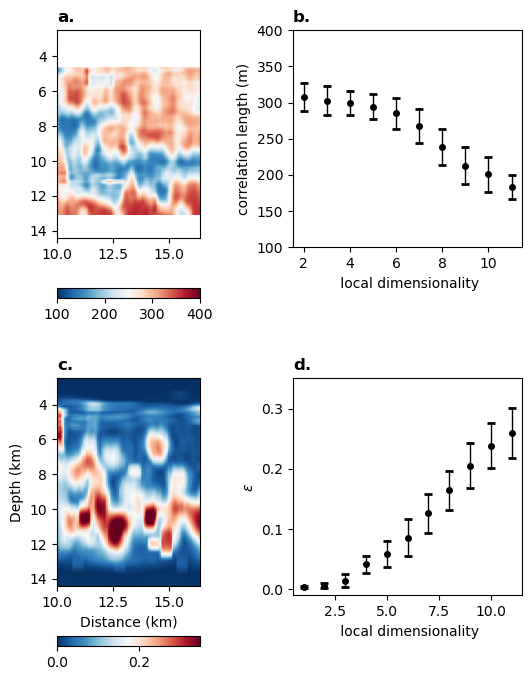

In [86]:

gs = {"hspace": 0.3, "wspace": 0.5, "width_ratios": [1.25, 2]}

fig, axs = plt.subplots(2, 2, figsize=(6, 8), gridspec_kw=gs,)
axs = axs.T

locdim = LOC_DIM[0]
dim = np.unique(LOC_DIM[0])

for i, par, title, cvalues in zip([0, 1], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):


    ax = axs[0]
    #im1 = ax[i].pcolor(x_dist, y_dist, par, cmap = 'RdBu_r', edgecolors='k', linewidths=0.01, rasterized = True, vmin = cvalues[0], vmax = cvalues[1])
    im1 = ax[i].imshow(par, cmap = 'RdBu_r', extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], rasterized = True, vmin = cvalues[0], vmax = cvalues[1], aspect = 'auto')


    ax[i].set_ylim(y_dist.max(), y_dist.min())
    ax[i].set_xlim(x_dist.min(), x_dist.max())

    divider = make_axes_locatable(ax[i])

    cax1 = divider.append_axes('bottom', size='5%', pad=0.5, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    #cbar.set_label(title)

    
    for j, dimen in enumerate(dim[::1]):
        ax = axs[1]

        qw = par.reshape(-1)[np.where(locdim==dimen)[0]]
        depth = np.repeat(y_dist, 65)[np.where(locdim==dimen)[0]]
        depth = depth[~np.isnan(qw)]

        qw = qw[~np.isnan(qw)]

        if len(qw) > 5:
            #bplot = ax[i].boxplot(qw, 0, 'rs', 0.,  positions=[j+1], widths = 0.4, patch_artist = True, showfliers = False, medianprops=dict(color="k"))
            bplot = ax[i].errorbar(j+1, np.mean(qw), yerr = np.std(qw)/2, lw = 1, fmt = 'o', markersize = 4, capsize = 3, capthick = 2, c = 'k', rasterized = True)
            #im = ax[i].scatter(np.ones_like(qw)*j+1, qw, c = depth, s = 20, alpha = 0.5, rasterized = True, vmin = 3, vmax = 13, facecolors='none', marker = "x" , zorder = 0)

        divider = make_axes_locatable(ax[i])

        cax1 = divider.append_axes('bottom', size='5%', pad=0.4, )
        cax1.axis('off')

axs[0, 1].set_xlabel('Distance (km)')
axs[0, 1].set_ylabel('Depth (km)')

axs[1, 0].set_ylim(100, 400)
axs[1, 1].set_ylim(-0.01, 0.35)

axs[1, 0].set_xlabel(' local dimensionality')
axs[1, 0].set_ylabel('correlation length (m)')


axs[1, 1].set_xlabel(' local dimensionality')
axs[1, 1].set_ylabel('$\epsilon$')
titl = ['a', 'b', 'c', 'd', 'e', 'f', 'g']


for i in range(4):
    axs.T.reshape(-1)[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

fig.tight_layout()
fig.savefig(savepath + "correlation_length_vs_local_dim_all" + ".png", bbox_inches="tight", dpi=300, transparent=True, )


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_58829/35932924.py:10: SyntaxWarning: invalid escape sequence '\e'
  for i, par, title, cvalues in zip([0, 1], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):
/tmp/ipykernel_58829/35932924.py:58: SyntaxWarning: invalid escape sequence '\e'
  axs[1, 1].set_ylabel('$\epsilon$')
/tmp/ipykernel_58829/35932924.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


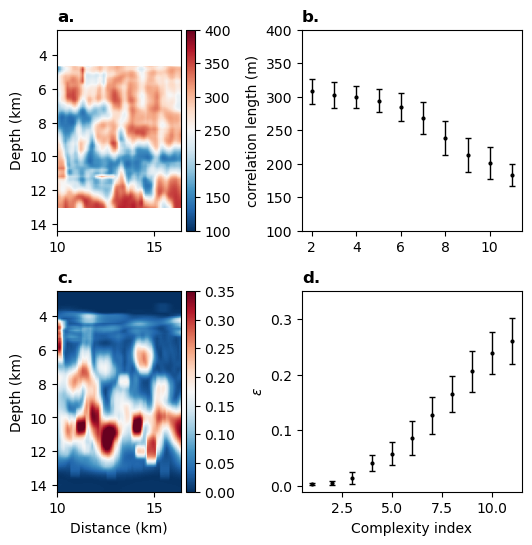

In [87]:

gs = {"hspace": 0.3, "wspace": 0.6, "width_ratios": [2.5, 4]}

fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=gs,)
axs = axs.T

locdim = LOC_DIM[0]
dim = np.unique(LOC_DIM[0])
cmaaps = ['RdBu_r', 'RdBu_r']

for i, par, title, cvalues in zip([0, 1], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):


    ax = axs[0]
    #im1 = ax[i].pcolor(x_dist, y_dist, par, cmap = 'RdBu_r', edgecolors='k', linewidths=0.01, rasterized = True, vmin = cvalues[0], vmax = cvalues[1])
    im1 = ax[i].imshow(par, cmap = cmaaps[i], extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], rasterized = True, vmin = cvalues[0], vmax = cvalues[1], aspect = 'auto')


    ax[i].set_ylim(y_dist.max(), y_dist.min())
    ax[i].set_xlim(x_dist.min(), x_dist.max())

    divider = make_axes_locatable(ax[i])

    cax1 = divider.append_axes('right', size='7%', pad=0.05, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='vertical')
    #cbar.set_label(title)

    #im1 = axs[i].scatter(par.reshape(-1), locdim, s=10, c = vs, alpha = 1, cmap = 'RdBu', edgecolors='k' , linewidths=0.05, rasterized = True)
    
    for j, dimen in enumerate(dim[::1]):
        ax = axs[1]

        qw = par.reshape(-1)[np.where(locdim==dimen)[0]]
        depth = np.repeat(y_dist, 65)[np.where(locdim==dimen)[0]]
        depth = depth[~np.isnan(qw)]

        qw = qw[~np.isnan(qw)]

        if len(qw) > 5:
            #bplot = ax[i].boxplot(qw, 0, 'rs', 0.,  positions=[j+1], widths = 0.4, patch_artist = True, showfliers = False, medianprops=dict(color="k"))
            bplot = ax[i].errorbar(j+1, np.mean(qw), yerr = np.std(qw)/2, fmt = 'o', lw =1, markersize = 2, capsize = 2, capthick = 1, c = 'k', rasterized = True)
            #im = ax[i].scatter(np.ones_like(qw)*j+1, qw, c = depth, s = 20, alpha = 0.5, rasterized = True, vmin = 3, vmax = 13, facecolors='none', marker = "x" , zorder = 0)


                
#axs[0, 0].set_xlabel('Distance (km)')
axs[0, 0].set_ylabel('Depth (km)')
axs[0, 1].set_xlabel('Distance (km)')
axs[0, 1].set_ylabel('Depth (km)')

axs[1, 0].set_ylim(100, 400)
axs[1, 1].set_ylim(-0.01, 0.35)

#axs[1, 0].set_xlabel('Complexity index')
axs[1, 0].set_ylabel('correlation length (m)')


axs[1, 1].set_xlabel('Complexity index')
axs[1, 1].set_ylabel('$\epsilon$')
titl = ['a', 'b', 'c', 'd', 'e', 'f', 'g']


for i in range(4):
    axs.T.reshape(-1)[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

fig.tight_layout()
fig.savefig(savepath + "correlation_length_vs_local_dim_all" + ".png", bbox_inches="tight", dpi=300, transparent=True, )


In [63]:
UMAPS_MODEL_HYPERPAR = []
UMAP_SPACE_HYPERPAR = []

k_neighbors = [10 , 30, 50, ]
min_distances = [0.1, 0.5, 0.9]

# Loop over hyperparameters
for i, neighbor in enumerate(k_neighbors):
    print(f'UMAP for data {i}')
    model_u = []
    space_u = []

    # Loop over hyperparameters
    for j, mindis in enumerate(min_distances):
        umodel = umap.UMAP(densmap=False, n_neighbors = neighbor,
                min_dist = mindis, n_components = 2,
                random_state = 42, 
                #metric = 'manhattan', local_connectivity = 20
                )
        
        space_u.append(umodel.fit_transform(scattering_coef_vs_norm))
        model_u.append(umodel)
        
    UMAPS_MODEL_HYPERPAR.append(model_u)
    UMAP_SPACE_HYPERPAR.append(space_u)
    

UMAP for data 0


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for data 1


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for data 2


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_58829/3426909008.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],


/tmp/ipykernel_58829/3426909008.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


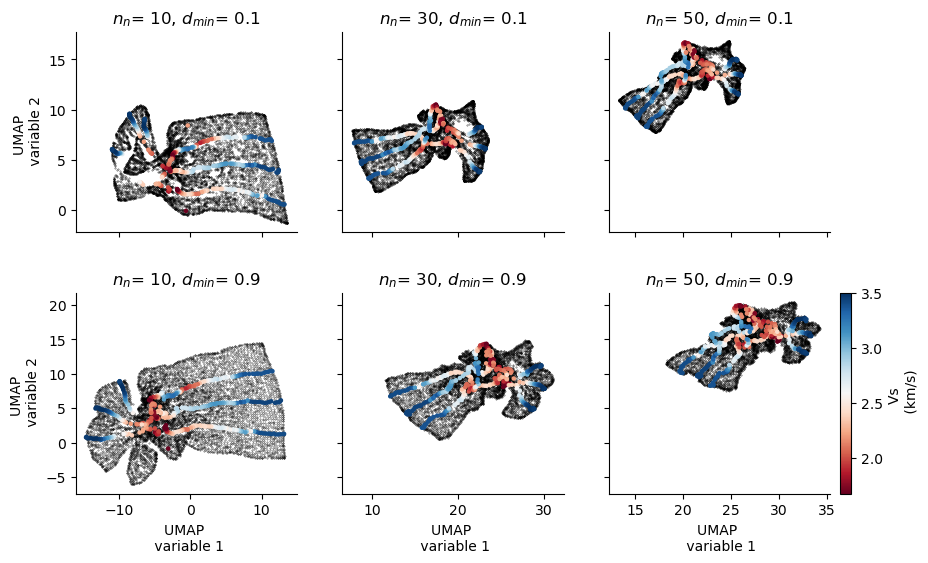

In [64]:

gs = {"hspace": 0.3, "wspace": 0.1, "height_ratios": [3, 3]}
fig, axs = plt.subplots(
        2, 3, figsize=(10, 6),  gridspec_kw=gs, sharex = 'col', sharey = 'row',
    )

for i, nn in enumerate(k_neighbors):
    for j, dd in enumerate(min_distances[::2]):

        im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0], 
            UMAP_SPACE_HYPERPAR[i][j][:, 1], c = 'k', cmap = 'RdBu', 
            s = 0.1, alpha = 0.75, rasterized=True)
        
        for k in vs_plotindex:
            im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][indxvs[:, k], 0], 
                UMAP_SPACE_HYPERPAR[i][j][indxvs[:, k], 1], 
                c = vs.reshape(-1)[indxvs[:, k]], cmap = 'RdBu',
                s = 5, alpha = 1, rasterized=True)
        
        axs[j, i].set_title('$n_{n}$' +f'= {nn}, ' +  '$d_{min}$'+ f'= {dd}')

        axs[j, i].spines['top'].set_visible(False)
        axs[j, i].spines['right'].set_visible(False)
        
        axs[1, i].set_xlabel('UMAP \n variable 1')
        axs[j, 0].set_ylabel('UMAP \n variable 2')

        if j == 1 and i == 2:
            divider = make_axes_locatable(axs[j, i])
            cax1 = divider.append_axes('right', size='5%', pad=0.1, )
            cbar = plt.colorbar(im, cax=cax1, orientation='vertical', label = 'Vs \n (km/s)', aspect = 0.5)
        
        else:
            divider = make_axes_locatable(axs[j, i])
            cax1 = divider.append_axes('right', size='5%', pad=0.1, )
            cax1.axis('off')

fig.tight_layout()
fig.savefig(savepath + "UMAP_hyperparameters" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [65]:
LOC_DIM_HYPERPAR = []
varaince_threshold = [0.45, 0.7, 0.9]

for i in (range(len(k_neighbors))):
    loc_dim_hyp = []
    for j in range(len(varaince_threshold)):
        loc_dim_hyp.append(calculate_local_dimension(UMAPS_MODEL_HYPERPAR[i][0], threshold = varaince_threshold[j]))

    LOC_DIM_HYPERPAR.append(loc_dim_hyp)
    print(f'UMAP for data {i}')
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:06<00:00, 1220.90it/s]


UMAP for data 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:25<00:00, 301.63it/s]


UMAP for data 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:32<00:00, 240.16it/s]

UMAP for data 2


/tmp/ipykernel_58829/2567571793.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


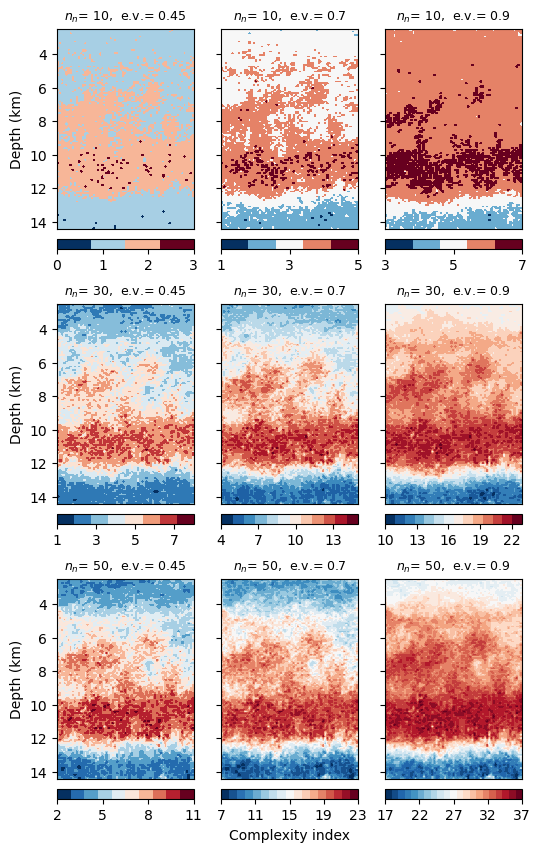

In [90]:


gs = {"hspace": 0.25, "wspace": 0.2, "height_ratios": [3, 3, 3]}

fig, axs = plt.subplots(
        3, 3, figsize=(6, 10),  gridspec_kw=gs, sharey = True, sharex = True,
    )

smp = [3, 5, 8]

for i, nn in enumerate(k_neighbors):
    for j, var in enumerate(varaince_threshold):        
        locdim = LOC_DIM_HYPERPAR[i][j]
        ncl = np.max(locdim) - np.min(locdim) + 1

        cmap = plt.get_cmap('RdBu_r', ncl)        
        # im = axs[i, j].pcolor(x_dist, y_dist, locdim.reshape(120, 65), cmap = cmap, 
        #                       vmin = locdim.min()-0, vmax = locdim.max(), 
        #                       edgecolors='k', linewidths=0.05, rasterized = True)
        
        im = axs[i, j].imshow( locdim.reshape(120, 65), cmap = cmap, 
                              vmin = locdim.min()-0, vmax = locdim.max(), 
                              rasterized = True, extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto')


        

        axs[i, j].set_title('$n_{n}$' +f'= {nn}, ' +  ' e.v.'+ f'= {var}', fontsize = 9)

        axs[i, j].set_ylim(y_dist.max(), y_dist.min())
        axs[i, j].set_xlim(x_dist.min(), x_dist.max())
        
        axs[i, 0].set_ylabel('Depth (km)')
        divider = make_axes_locatable(axs[i, j])

        cax1 = divider.append_axes('bottom', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax1, orientation='horizontal', aspect = 1, ticks=np.arange(locdim.min(), locdim.max() + 1)[::1+ncl//5]+0)
        
        axs[i, j].set_xticks([])
        #cbar.set_label('Local dimensionality')
        
        if j == 1 and i == 2:
            cbar.set_label('Complexity index')
            
            
fig.tight_layout()
fig.savefig(savepath + "UMAP_hyperparameters_dimensionality" + ".png", bbox_inches="tight", dpi=300, transparent=True)



In [67]:
radii = 2
loc_dim_model =  np.zeros_like(vs)
threshold = 0.75

for i in tqdm(range(vs.shape[0]), ):
    for j in range(vs.shape[1]):
        vicinity_ij = get_vicinity_elements(indxvs, i, j, radii).reshape(-1)
        pca = PCA()
        pca.fit_transform(scattering_coef_vs_norm[vicinity_ij, : ])
        loc_dim_model[i, j] = len(np.where(np.cumsum(pca.explained_variance_ratio_) < threshold)[0])
        
loc_dim_model2 =  np.zeros_like(vs)
for i in tqdm(range(vs.shape[0]), ):
    for j in range(vs.shape[1]):
        vicinity_ij = get_vicinity_elements(indxvs, i, j, radii).reshape(-1)
        pca = PCA()
        pca.fit_transform(scattering_coef_hs_norm[vicinity_ij, : ])
        loc_dim_model2[i, j] = len(np.where(np.cumsum(pca.explained_variance_ratio_) < threshold)[0])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:25<00:00,  4.70it/s]


(15,)

In [69]:


entropy = np.zeros_like(vs)

for i in tqdm(range(vs.shape[0])):
    for j in range(vs.shape[1]):
        vicinity_ij = get_vicinity_elements(indxvs, i, j, radii).reshape(-1)
        data_selected = scattering_coef_vs_norm[vicinity_ij, : ]
        
        U, s, V = np.linalg.svd(data_selected, full_matrices=False)
        s = s / np.max(s)
        
        entropy[i, j] = -np.sum(s * np.log(s+1e-10))
        



entropy2 = np.zeros_like(vs)

for i in tqdm(range(vs.shape[0])):
    for j in range(vs.shape[1]):
        vicinity_ij = get_vicinity_elements(indxvs, i, j, radii).reshape(-1)
        data_selected = scattering_coef_hs_norm[vicinity_ij, : ]
        
        U, s, V = np.linalg.svd(data_selected, full_matrices=False)
        s = s / np.max(s)
        
        entropy2[i, j] = -np.sum(s * np.log(s+1e-10))
        

    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:22<00:00,  5.30it/s]


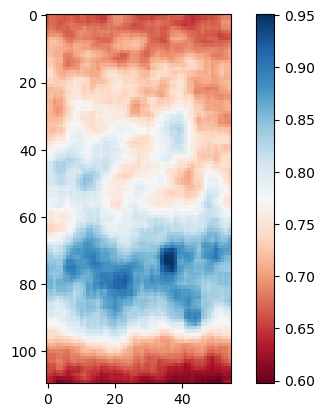

In [70]:

plt.imshow(entropy[5:-5,5:-5], cmap = 'RdBu',  rasterized = True)
plt.colorbar()


/tmp/ipykernel_58829/1282374118.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


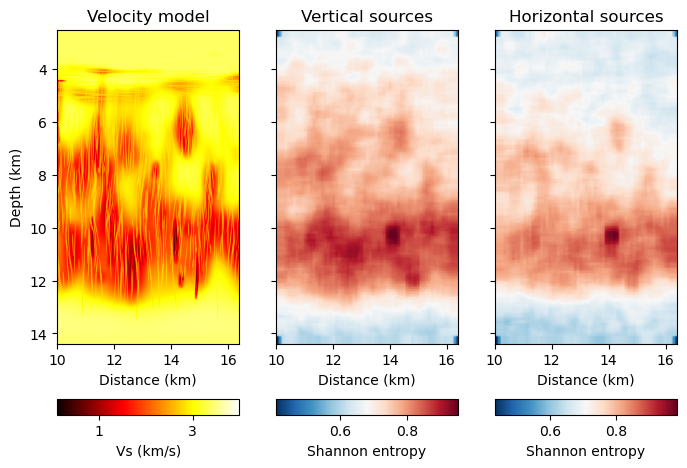

In [71]:


gs = {"hspace": 0.0, "wspace": 0.2, "width_ratios": [1, 1,  1]}
fig, axs = plt.subplots(
    1, 3, figsize=(8, 5),  gridspec_kw=gs, sharex = True, sharey = True,
    )

im1 = axs[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, aspect = 'auto')


axs[0].set_ylim(y_dist.max(), y_dist.min())
axs[0].set_ylabel('Depth (km)')
axs[0].set_xlabel('Distance (km)')
#axs[0].axis('off')
# 
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(1, 21 + 1)[::2])
cbar.set_label('Vs (km/s)')

for i, loc_dim in enumerate([entropy, entropy2]):

    cmap = plt.get_cmap('RdBu_r')
    
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = axs[i+1].imshow(loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto', rasterized = True)
    axs[i+1].set_ylim(y_dist.max(), y_dist.min())
    axs[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    axs[i+1].set_xlabel('Distance (km)')
    divider = make_axes_locatable(axs[i+1])
    cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    cbar.set_label('Shannon entropy')

[axs[i].set_title(f) for i, f in enumerate(['Velocity model', 'Vertical sources', 'Horizontal sources'])]

fig.tight_layout()
fig.savefig(savepath + f"UMAP_LOCAL_Entropy_on_model_raddi_{radii}" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


/tmp/ipykernel_58829/3874748069.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


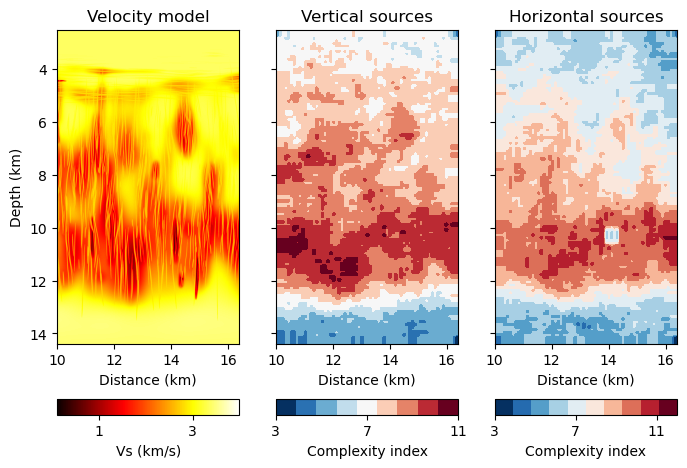

In [72]:

gs = {"hspace": 0.0, "wspace": 0.2, "width_ratios": [1, 1,  1]}
fig, axs = plt.subplots(
    1, 3, figsize=(8, 5),  gridspec_kw=gs, sharex = True, sharey = True,
    )

im1 = axs[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, aspect = 'auto')


axs[0].set_ylim(y_dist.max(), y_dist.min())
axs[0].set_ylabel('Depth (km)')
axs[0].set_xlabel('Distance (km)')
#axs[0].axis('off')
# 
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(1, 21 + 1)[::2])
cbar.set_label('Vs (km/s)')

for i, loc_dim in enumerate([loc_dim_model, loc_dim_model2]):

    cmap = plt.get_cmap('RdBu_r', np.max(loc_dim) - np.min(loc_dim) + 1)
    
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = axs[i+1].imshow(loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto', rasterized = True)
    axs[i+1].set_ylim(y_dist.max(), y_dist.min())
    axs[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    axs[i+1].set_xlabel('Distance (km)')
    divider = make_axes_locatable(axs[i+1])
    cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(loc_dim.min(), loc_dim.max() + 1)[::4])
    cbar.set_label('Complexity index')

[axs[i].set_title(f) for i, f in enumerate(['Velocity model', 'Vertical sources', 'Horizontal sources'])]

fig.tight_layout()
fig.savefig(savepath + f"UMAP_LOCAL_DIMENSIONALITY_on_model_raddi_{radii}" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [74]:
ENTROPY_ = []

for i , umodel in enumerate(UMAP_model):
    print(f'UMAP for data {i}')
    ENTROPY_.append(calculate_entropy_in_umap(umodel, threshold = 0.6))
    

UMAP for data 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:31<00:00, 245.04it/s]


UMAP for data 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:30<00:00, 252.41it/s]


[Text(0.5, 1.0, 'Velocity model'),
 Text(0.5, 1.0, 'Vertical sources'),
 Text(0.5, 1.0, 'Horizontal sources')]

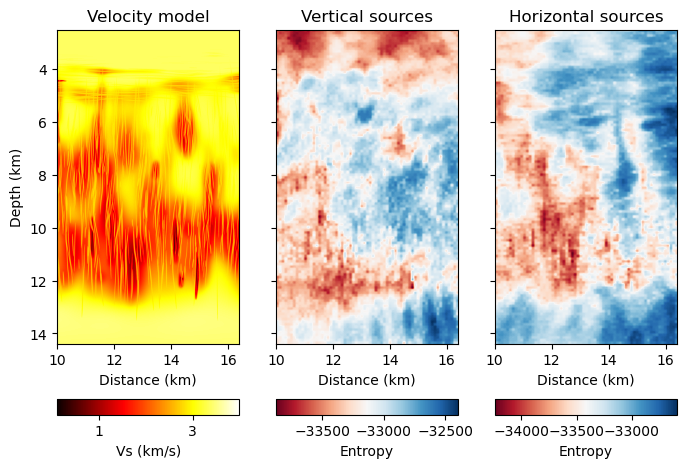

In [75]:

gs = {"hspace": 0.0, "wspace": 0.2, "width_ratios": [1, 1,  1]}
fig, axs = plt.subplots(
    1, 3, figsize=(8, 5),  gridspec_kw=gs, sharex = True, sharey = True,
    )

im1 = axs[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, aspect = 'auto')

axs[0].set_ylim(y_dist.max(), y_dist.min())
axs[0].set_ylabel('Depth (km)')
axs[0].set_xlabel('Distance (km)')
#axs[0].axis('off')
# 
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=np.arange(1, 21 + 1)[::2])
cbar.set_label('Vs (km/s)')

for i, loc_dim in enumerate(ENTROPY_):
    cmap = plt.get_cmap('RdBu_r')
    
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = axs[i+1].imshow(loc_dim.reshape(120, 65), cmap = 'RdBu',  extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto', rasterized = True)
    axs[i+1].set_ylim(y_dist.max(), y_dist.min())
    axs[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    axs[i+1].set_xlabel('Distance (km)')
    divider = make_axes_locatable(axs[i+1])
    cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
    cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    cbar.set_label('Entropy')
    
[axs[i].set_title(f) for i, f in enumerate(['Velocity model', 'Vertical sources', 'Horizontal sources'])]

# fig.tight_layout()
# fig.savefig(savepath + "UMAP_LOCAL_ENTROLPY" + ".png", bbox_inches="tight", dpi=300, transparent=True,)

    


In [ ]:
calc

In [32]:

LOCAL_ENTROPY_HYPER = []

for i in (range(len(k_neighbors))):

    LOCAL_ENTROPY_HYPER.append(calculate_entropy_in_umap(UMAPS_MODEL_HYPERPAR[i][0]))
    
    print(f'UMAP for data {i}')



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:06<00:00, 1257.71it/s]


UMAP for data 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:24<00:00, 315.62it/s]


UMAP for data 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:26<00:00, 293.35it/s]

UMAP for data 2


/tmp/ipykernel_117022/3233345823.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


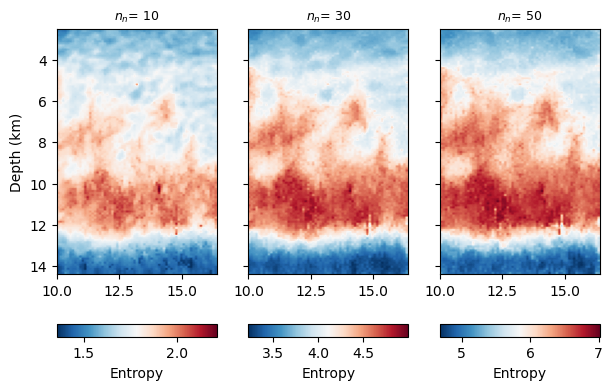

In [34]:



gs = {"hspace": 0.3, "wspace": 0.2, "height_ratios": [1]}

fig, axs = plt.subplots(
        1, 3, figsize=(7, 4),  gridspec_kw=gs, sharey = True, sharex = True,
    )



smp = [3, 5, 8]

for i, nn in enumerate(k_neighbors):
    locdim = LOCAL_ENTROPY_HYPER[i]
    ncl = np.max(locdim) - np.min(locdim) + 1
    cmap = plt.get_cmap('RdBu_r')

    im = axs[i].imshow( locdim.reshape(120, 65), cmap = cmap, 
                            vmin = locdim.min()-0, vmax = locdim.max(), 
                            rasterized = True, extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], aspect = 'auto')
  

    divider = make_axes_locatable(axs[i])

    cax1 = divider.append_axes('bottom', size='5%', pad=0.5)
    cbar = plt.colorbar(im, cax=cax1, orientation='horizontal', aspect = 1)


    cbar.set_label('Entropy')

    axs[i].set_title('$n_{n}$' +f'= {nn}', fontsize = 9)

    axs[0].set_ylabel('Depth (km)')

fig.tight_layout()
fig.savefig(savepath + "UMAP_Entropy_dimensionality" + ".png", bbox_inches="tight", dpi=300, transparent=True)


In [85]:
vicinity_ij.shape


(45,)

(70.0, 130.0)

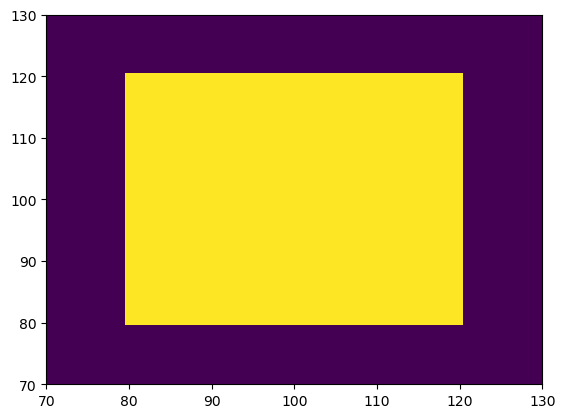

In [118]:
radii = 20
vicinity_ij = get_vicinity_elements(indxvs_hr, 100, 100, radii).reshape(-1)


vsss = vs_hr.copy().reshape(-1)

vsss[:] = 0

vsss[vicinity_ij] = 100
vsss = vsss.reshape(vs_hr_shape[0], vs_hr_shape[1])

plt.imshow(vsss, aspect = 'auto')
plt.xlim(70, 130)
plt.ylim(70, 130)


In [109]:
def calculate_std(model, radii):
    f"""
    Calculate the standard deviation of the given model.

    Parameters:
    model (numpy.ndarray): The model for which to calculate the standard deviation.

    Returns:
    float: The standard deviation of the model.
    """
    
    model_shape_i, model_shape_j = model.shape

    indxvs_hr = np.arange(model_shape_i* model_shape_j).reshape(model_shape_i, model_shape_j)
    vs_std = np.zeros_like(model)

    for i in tqdm(range(model_shape_i):
        for j in range(model_shape_j):

            vicinity_ij = get_vicinity_elements(indxvs_hr, i, j, radii).reshape(-1)
            data_selected = model.reshape(-1)[vicinity_ij]
            vs_std[i, j] = np.std(data_selected)/ np.mean(data_selected)
    
    return vs_std


500

In [110]:
radii = 50


vs_hr_shape = vs_hr.shape
indxvs_hr = np.arange(vs_hr_shape[0]* vs_hr_shape[1]).reshape(vs_hr_shape[0], vs_hr_shape[1])
vs_std = np.zeros_like(vs_hr)

for i in tqdm(range(vs_hr.shape[0])):
    for j in range(vs_hr.shape[1]):

        vicinity_ij = get_vicinity_elements(indxvs_hr, i, j, radii).reshape(-1)
        data_selected = vs_hr.reshape(-1)[vicinity_ij]
        vs_std[i, j] = np.std(data_selected)/ np.mean(data_selected)
        

  0%|                                                                                                                                                                                                                                                                       | 0/2400 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [02:51<00:00, 13.98it/s]


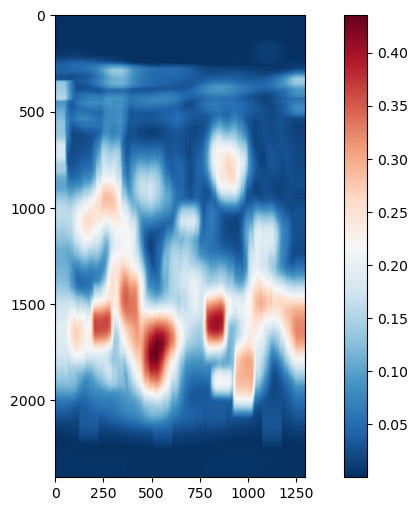

In [133]:
plt.figure(figsize=(10, 6))

plt.imshow(vs_std, cmap = 'RdBu_r')
plt.colorbar()


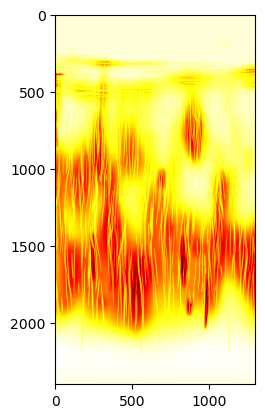

In [134]:
plt.imshow(vs_hr, cmap = 'hot')

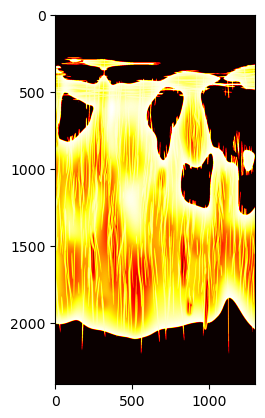

In [153]:

mask = vs_hr.copy()
mask[mask>3] = 0
plt.imshow(mask, cmap = 'hot')



In [150]:
mask


array([[3.3813212, 3.3813212, 3.3813212, ..., 3.3813212, 3.3813212,
        3.3813212],
       [3.3813212, 3.3813212, 3.3813212, ..., 3.3813212, 3.3813212,
        3.3813212],
       [3.3813212, 3.3813212, 3.3813212, ..., 3.3813212, 3.3813212,
        3.3813212],
       ...,
       [3.4325476, 3.4325378, 3.4325278, ..., 3.429839 , 3.4298363,
        3.4298337],
       [3.4322047, 3.4321952, 3.4321854, ..., 3.4295437, 3.4295413,
        3.4295387],
       [3.4318647, 3.431855 , 3.4318452, ..., 3.4292502, 3.429248 ,
        3.4292462]], dtype=float32)

In [ ]:
def add_perturbation(model, mean=0, std=0.1, x_threshold=0.5):
    """
    Adds Gaussian noise to the part of the model with higher x values.

    Parameters:
    model (numpy.ndarray): The original model to which perturbations will be added.
    mean (float): The mean of the Gaussian noise.
    std (float): The standard deviation of the Gaussian noise.
    x_threshold (float): The threshold for x values to apply perturbation. Should be between 0 and 1.

    Returns:
    numpy.ndarray: The perturbed model.
    """
    noise = np.random.normal(mean, std, model.shape)
    perturbed_model = model.copy()
    
    # Apply perturbation to the part of the model with higher x values
    x_split = int(model.shape[1] * x_threshold)
    perturbed_model[:, x_split:] += noise[:, x_split:]
    

    return perturbed_model

# Example usage:
perturbed_vs_hr = add_perturbation(vs_hr, mean=0, std=0.1, x_threshold=0.5)
plt.imshow(perturbed_vs_hr, cmap='hot')
plt.colorbar()
plt.title('Perturbed Model with Higher X Values')
plt.show()
def add_perturbation_above_threshold(model, threshold, mean=0, std=0.1):
    """
    Adds Gaussian noise to the elements of the model that are above a specific threshold.

    Parameters:
    model (numpy.ndarray): The original model to which perturbations will be added.
    threshold (float): The value above which perturbations will be applied.
    mean (float): The mean of the Gaussian noise.
    std (float): The standard deviation of the Gaussian noise.

    Returns:
    numpy.ndarray: The perturbed model.
    """
    noise = np.random.normal(mean, std, model.shape)
    perturbed_model = model.copy()
    
    # Apply perturbation to elements above the threshold
    perturbed_model[model > threshold] += noise[model > threshold]
    
    return perturbed_model

# Example usage:
perturbed_vs_hr_threshold = add_perturbation_above_threshold(vs_hr, threshold=2.5, mean=0, std=0.1)
plt.imshow(perturbed_vs_hr_threshold, cmap='hot')
plt.colorbar()
plt.title('Perturbed Model with Elements Above Threshold')
plt.show()